In [1]:
!git clone https://github.com/dmc27/missing_pixels.git

Cloning into 'missing_pixels'...
remote: Enumerating objects: 59, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 59 (delta 0), reused 0 (delta 0), pack-reused 56
Receiving objects: 100% (59/59), 11.59 MiB | 23.55 MiB/s, done.


In [1]:
import os.path
from os import listdir
from os.path import isfile, join

import cv2 as cv

from sklearn.metrics import accuracy_score

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import load_model
from keras.callbacks import ModelCheckpoint

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

plt.rcParams["figure.dpi"] = 120

from IPython.display import HTML
shell = get_ipython()

def adjust_font_size():
  display(HTML('''<style>
    body {
      font-size: 16px;
    }
  '''))

if adjust_font_size not in shell.events.callbacks['pre_execute']:
  shell.events.register('pre_execute', adjust_font_size)


NUM_INP_NODES = 60
NUM_OUT_NODES = 4
BLOCK_SIZE = 8
M1 = 3
M2 = 4
C1 = 0
C2 = 7

2023-07-25 18:18:43.596396: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-07-25 18:18:43.621723: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-25 18:18:44.016783: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [3]:
def is_missing_pixel(r, c):
  return (r >= M1 and c >= M1 and r <= M2 and c <= M2)

def do_parse_img(img, inps, tgts):
  num_rows = img.shape[0]
  num_cols = img.shape[1]

  inp = np.zeros((NUM_INP_NODES))
  tgt = np.zeros((NUM_OUT_NODES))

  for r0 in range(0, num_rows, BLOCK_SIZE):
    for c0 in range(0, num_cols, BLOCK_SIZE):
      # extract and reshape a block of the image
      pos1 = 0
      pos2 = 0
      for r in range(BLOCK_SIZE):
        for c in range(BLOCK_SIZE):
          assert(r0 + r < num_rows)
          assert(c0 + c < num_cols)

          if is_missing_pixel(r, c):
            tgt[pos2] = img[r0 + r, c0 + c]
            pos2 += 1
          else:
            inp[pos1] = img[r0 + r, c0 + c]
            pos1 += 1

      # add the input and target patterns
      inps.append(inp.copy() / 255.0)
      tgts.append(tgt.copy() / 255.0)


def imshow(img, cmap=None, vmin=0, vmax=255, frameon=False, dpi=72):
  fig = plt.figure(figsize=[img.shape[1]/dpi, img.shape[0]/dpi], \
                   frameon=frameon)
  ax = fig.add_axes([0, 0, 1, 1])
  ax.axis('off')
  ax.imshow(img, cmap=cmap, vmin=vmin, vmax=vmax)
  plt.show()

In [6]:
#%% LOAD THE TRAINING DATA
img_path = "./missing_pixels"
img_fnames = [f for f in listdir(img_path) if isfile(join(img_path, f))]
print(img_fnames)

inps = []
tgts = []
num_imgs = 0
for img_fname in img_fnames:

  # skip the image(s) used for testing
  if (img_fname.lower() == "balloon.bmp"):
    continue

  print(img_fname)
  img = cv.imread(join(img_path, img_fname), cv.IMREAD_GRAYSCALE)
  img = cv.resize(img, (256, 256), cv.INTER_LINEAR)
  img = img.astype(np.float64)

  do_parse_img(img, inps, tgts)

  num_imgs += 1
  if (num_imgs > 25):
    break

print("num_imgs =", num_imgs)

X_trn = np.zeros((len(inps), NUM_INP_NODES))
y_trn = np.zeros((len(tgts), NUM_OUT_NODES))
for idx in range(len(inps)):
  X_trn[idx, :] = inps[idx]
  y_trn[idx] = tgts[idx]

['rainriver.bmp', 'sealion.bmp', 'horse.bmp', 'hawaii.bmp', 'branches.bmp', 'rooster.bmp', 'tulips.bmp', 'rabbits.bmp', 'man.bmp', 'baboon.bmp', 'beans.bmp', 'zelda.bmp', 'bushes.bmp', 'BEACH.BMP', 'valley.bmp', 'peppers.bmp', '1fnoise.bmp', 'peak.bmp', 'fruits.bmp', 'PUMPKINS.BMP', 'airplane.bmp', 'KIDS.BMP', 'lena.bmp', 'TABLE.BMP', 'FOOTBALL.BMP', 'HOUSE.BMP', 'kid.bmp', 'SAIL.BMP', 'lily.bmp', 'buds.bmp', 'pelicans.bmp', 'desert.bmp', 'eagle.bmp', 'pony.bmp', 'WALL.BMP', 'FLOWERS.BMP', 'deer.bmp', 'birds.bmp', 'frog.bmp', 'fox.bmp', 'duck.bmp', 'barbara.bmp', 'bark.bmp', 'barn.bmp', 'sheep.bmp', 'tank.bmp', 'stream.bmp', 'bricks.bmp', 'helen.bmp', 'TRAIN.BMP', 'bridge.bmp', 'baby.bmp', 'cactus.bmp', 'dune2.bmp', 'balloon.bmp']
rainriver.bmp
sealion.bmp
horse.bmp
hawaii.bmp
branches.bmp
rooster.bmp
tulips.bmp
rabbits.bmp
man.bmp
baboon.bmp
beans.bmp
zelda.bmp
bushes.bmp
BEACH.BMP
valley.bmp
peppers.bmp
1fnoise.bmp
peak.bmp
fruits.bmp
PUMPKINS.BMP
airplane.bmp
KIDS.BMP
lena.bmp
TABLE

In [7]:
#%% CREATE OR LOAD THE MODEL
reuse_pre_model = False

# previous model exists?
model_fname = "model.0.h5"
if reuse_pre_model and os.path.exists(model_fname):
  print("Reloading previous model: ", model_fname)
  model = load_model(model_fname)
else:
  print("Creating new model")
  model = Sequential()
  model.add(Dense(120, input_shape=(NUM_INP_NODES,),
    activation="relu"))
  model.add(Dense(60, activation="relu"))
  model.add(Dense(NUM_OUT_NODES, activation='sigmoid'))

  # compile the keras model
  model.compile(loss="mean_squared_error", optimizer="adam",
    metrics=["accuracy"])

# show the model info
model.summary()


Creating new model
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 120)               7320      
                                                                 
 dense_1 (Dense)             (None, 60)                7260      
                                                                 
 dense_2 (Dense)             (None, 4)                 244       
                                                                 
Total params: 14,824
Trainable params: 14,824
Non-trainable params: 0
_________________________________________________________________


2023-07-25 18:14:38.379170: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-07-25 18:14:38.379500: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-07-25 18:14:38.396173: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [8]:
# DO THE TRAINING
checkpoint = ModelCheckpoint(model_fname, monitor='loss', verbose=1,
  save_best_only=True)
callbacks_list = [checkpoint]

# fit the model
history = model.fit(X_trn, y_trn, epochs=450, batch_size=512,
  validation_split=0.1, callbacks=callbacks_list)
# history = model.fit(X_trn, y_trn, epochs=200, batch_size=1,
#   validation_split=0.1, callbacks=callbacks_list)

Epoch 1/450


2023-07-25 18:14:40.426576: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:637] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-07-25 18:14:40.626508: I tensorflow/compiler/xla/service/service.cc:169] XLA service 0x7f38b0c599b0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-07-25 18:14:40.626525: I tensorflow/compiler/xla/service/service.cc:177]   StreamExecutor device (0): NVIDIA GeForce RTX 3090, Compute Capability 8.6
2023-07-25 18:14:40.626529: I tensorflow/compiler/xla/service/service.cc:177]   StreamExecutor device (1): NVIDIA GeForce RTX 3070 Ti, Compute Capability 8.6
2023-07-25 18:14:40.628905: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-07-25 18:14:40.637748: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8600
2023-07-

43/47 [==========================>...] - ETA: 0s - loss: 0.0348 - accuracy: 0.2676 
Epoch 1: loss improved from inf to 0.03347, saving model to model.0.h5
47/47 [==============================] - 1s 3ms/step - loss: 0.0335 - accuracy: 0.2694 - val_loss: 0.0159 - val_accuracy: 0.3143
Epoch 2/450
46/47 [============================>.] - ETA: 0s - loss: 0.0092 - accuracy: 0.3341
Epoch 2: loss improved from 0.03347 to 0.00919, saving model to model.0.h5
47/47 [==============================] - 0s 2ms/step - loss: 0.0092 - accuracy: 0.3353 - val_loss: 0.0052 - val_accuracy: 0.3793
Epoch 3/450
45/47 [===========================>..] - ETA: 0s - loss: 0.0052 - accuracy: 0.3854
Epoch 3: loss improved from 0.00919 to 0.00520, saving model to model.0.h5
47/47 [==============================] - 0s 2ms/step - loss: 0.0052 - accuracy: 0.3853 - val_loss: 0.0045 - val_accuracy: 0.4048
Epoch 4/450
46/47 [============================>.] - ETA: 0s - loss: 0.0045 - accuracy: 0.4046
Epoch 4: loss improved 

/tmp/ipykernel_222897/913440149.py:26: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


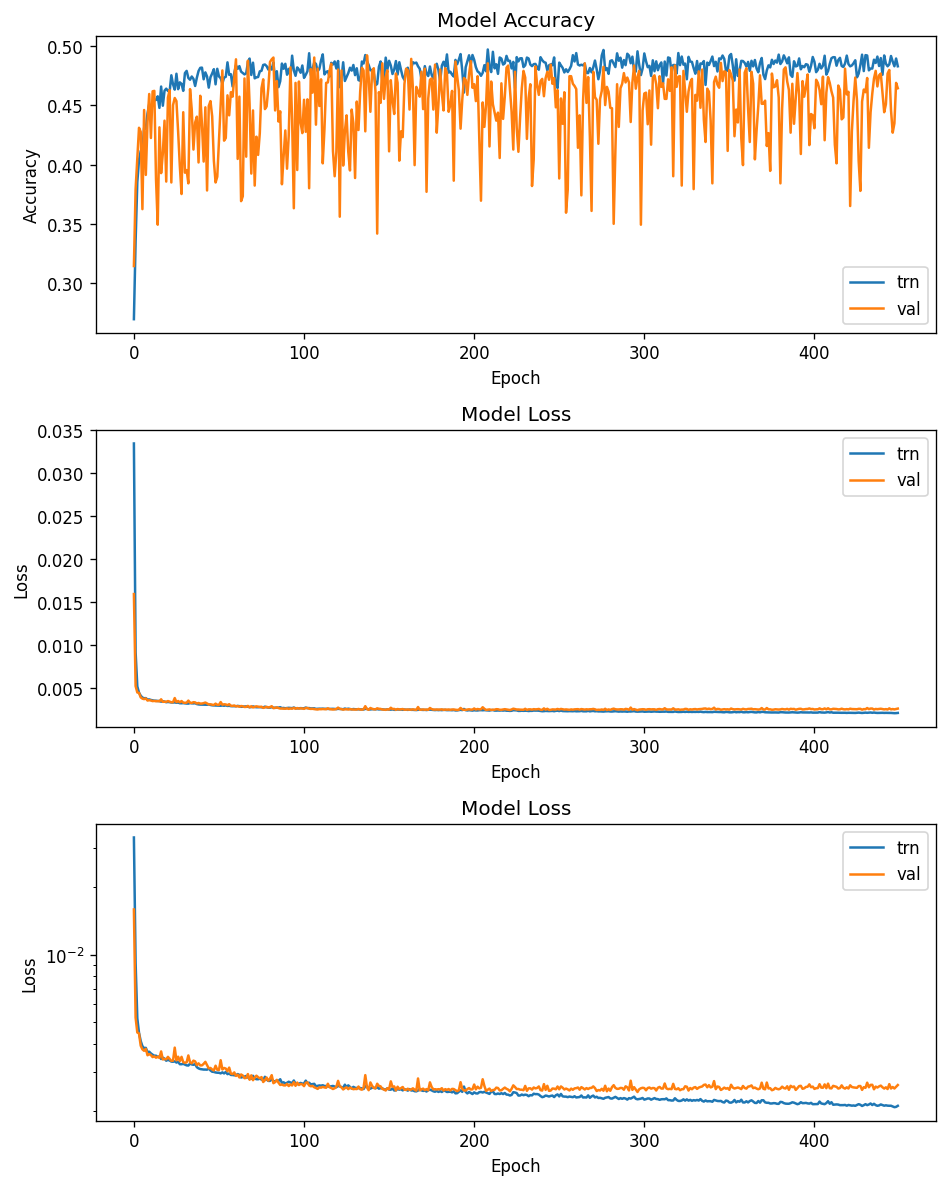

In [9]:
fig = plt.figure(figsize=(8, 10))
plt.subplot(3,1,1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['trn', 'val'], loc='lower right')

plt.subplot(3,1,2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['trn', 'val'], loc='upper right')
plt.tight_layout()

plt.subplot(3,1,3)
plt.semilogy(history.history['loss'])
plt.semilogy(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['trn', 'val'], loc='upper right')
plt.tight_layout()


32/32 [==============================] - 0s 515us/step
MSE = 17.50


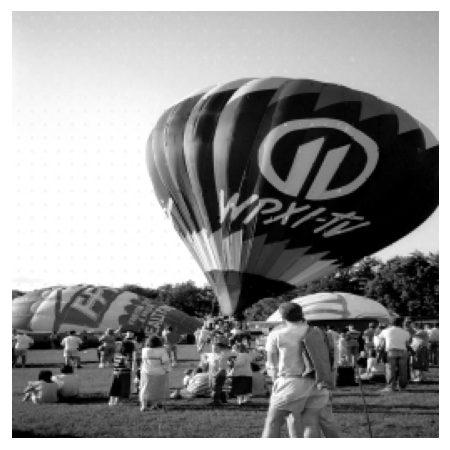

In [16]:
img = cv.imread(join(img_path, "balloon.bmp"), cv.IMREAD_GRAYSCALE)
img = cv.resize(img, (256, 256), cv.INTER_CUBIC)
img = img.astype(np.float64)

inps = []
tgts = []
do_parse_img(img, inps, tgts)

X_tst = np.zeros((len(inps), NUM_INP_NODES))
y_tst = np.zeros((len(tgts), NUM_OUT_NODES))
for idx in range(len(inps)):
  X_tst[idx, :] = inps[idx]
  y_tst[idx] = tgts[idx]

# predict the missing pixels
y_tst_prd = model.predict(X_tst)

num_rows = img.shape[0]
num_cols = img.shape[1]
rec_img = np.zeros((num_rows, num_cols))

blk_pos = 0
for r0 in range(0, num_rows, BLOCK_SIZE):
  for c0 in range(0, num_cols, BLOCK_SIZE):
    # fill in the outer and context pixels
    for r in range(BLOCK_SIZE):
      for c in range(BLOCK_SIZE):
        assert(r0 + r < num_rows)
        assert(c0 + c < num_cols)
        if not is_missing_pixel(r, c):
          rec_img[r0 + r, c0 + c] = img[r0 + r, c0 + c]

    out = y_tst_prd[blk_pos]
    blk_pos += 1

    # fill in the missing pixels
    pos = 0
    for r in range(BLOCK_SIZE):
      for c in range(BLOCK_SIZE):
        assert(r0 + r < num_rows)
        assert(c0 + c < num_cols)
        if is_missing_pixel(r, c):
          rec_img[r0 + r, c0 + c] = 255*out[pos]
          pos += 1

# compute the MSE between the original and reconstructed images
err = rec_img - img
print("MSE =", "{:.2f}".format((err**2).mean()))

imshow(rec_img, "gray", dpi=72)
# plt.axis("off")
